In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Mon Jan 22 03:02:45 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   52C    P0    74W / 300W |  27899MiB / 80994MiB |     41%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = -3
hp.const_sigma = True
hp.quantize = False
hp.prior_mu = 0.999

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_0.9999_-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

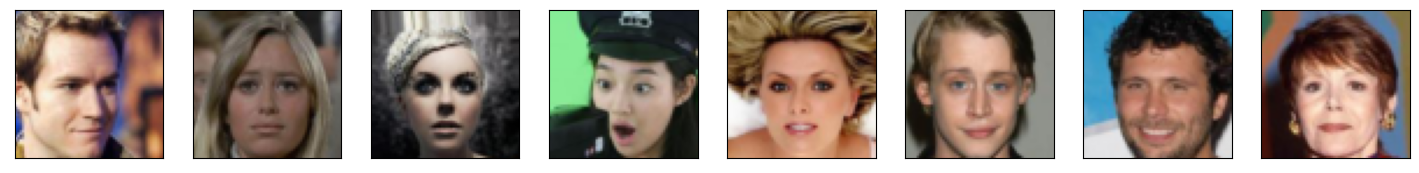

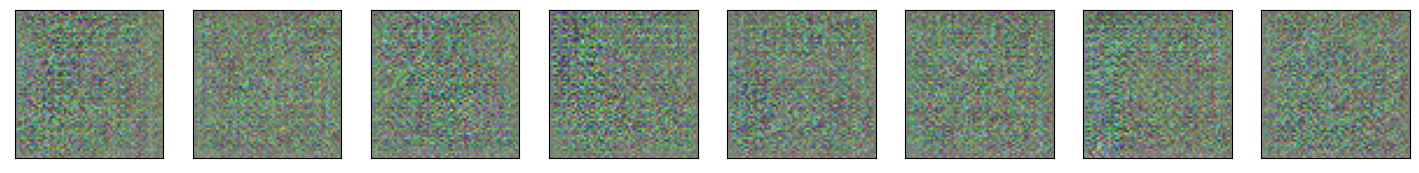

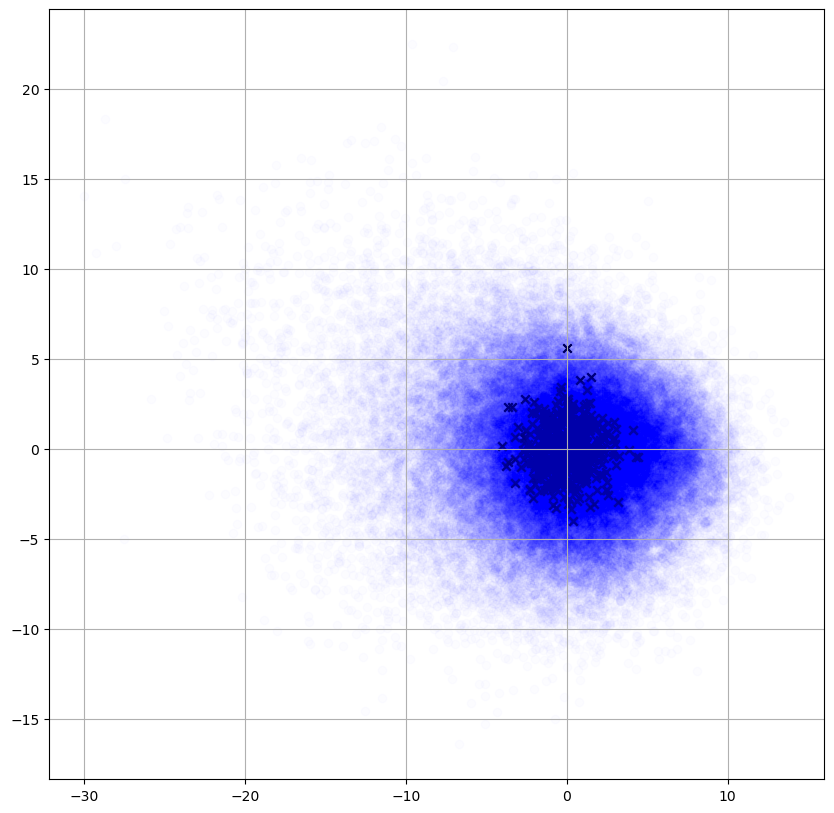

1
lse_loss 25520.5234375
commit_loss 5.187213897705078
recon_loss 0.1028042584657669
2
lse_loss 23508.986328125
commit_loss 4.988710880279541
recon_loss 0.09944699704647064
3
lse_loss 22016.783203125
commit_loss 4.853693008422852
recon_loss 0.09666906297206879
4
lse_loss 19656.341796875
commit_loss 4.69732666015625
recon_loss 0.10108426213264465
5
lse_loss 18185.16015625
commit_loss 4.60264778137207
recon_loss 0.09380048513412476
6
lse_loss 17066.33984375
commit_loss 4.505728721618652
recon_loss 0.09203803539276123
7
lse_loss 15683.7021484375
commit_loss 4.438177108764648
recon_loss 0.08925080299377441
8
lse_loss 14239.3486328125
commit_loss 4.36117696762085
recon_loss 0.08730541169643402
9
lse_loss 13352.109375
commit_loss 4.278683662414551
recon_loss 0.087408147752285
10
lse_loss 12451.369140625
commit_loss 4.223928928375244
recon_loss 0.08438413590192795
11
lse_loss 12251.1826171875
commit_loss 4.179140090942383
recon_loss 0.07896716892719269
12
lse_loss 11744.5849609375
commit_loss

93
lse_loss 7768.61083984375
commit_loss 2.4265716075897217
recon_loss 0.027778849005699158
94
lse_loss 7729.38671875
commit_loss 2.4448981285095215
recon_loss 0.028606999665498734
95
lse_loss 7796.27978515625
commit_loss 2.4311366081237793
recon_loss 0.02841576188802719
96
lse_loss 7794.7802734375
commit_loss 2.4387216567993164
recon_loss 0.02780480682849884
97
lse_loss 7638.30224609375
commit_loss 2.3902463912963867
recon_loss 0.027178041636943817
98
lse_loss 7649.07373046875
commit_loss 2.3463053703308105
recon_loss 0.0287699606269598
99
lse_loss 7593.26904296875
commit_loss 2.4036598205566406
recon_loss 0.028345031663775444
100
lse_loss 7683.52294921875
commit_loss 2.36470627784729
recon_loss 0.027255799621343613
101
lse_loss 7629.23193359375
commit_loss 2.373612642288208
recon_loss 0.0273604616522789
102
lse_loss 7553.63330078125
commit_loss 2.3678555488586426
recon_loss 0.02651466242969036
103
lse_loss 7560.81298828125
commit_loss 2.3261423110961914
recon_loss 0.02628907933831215

183
lse_loss 6458.68017578125
commit_loss 1.8792911767959595
recon_loss 0.016211260110139847
184
lse_loss 6438.17138671875
commit_loss 1.8510576486587524
recon_loss 0.016105536371469498
185
lse_loss 6376.09912109375
commit_loss 1.882189393043518
recon_loss 0.01658756285905838
186
lse_loss 6378.60986328125
commit_loss 1.818822979927063
recon_loss 0.016421549022197723
187
lse_loss 6353.21923828125
commit_loss 1.8821337223052979
recon_loss 0.016305487602949142
188
lse_loss 6334.2421875
commit_loss 1.8491284847259521
recon_loss 0.015615194104611874
189
lse_loss 6274.50146484375
commit_loss 1.8833304643630981
recon_loss 0.01617751270532608
190
lse_loss 6333.30078125
commit_loss 1.8344730138778687
recon_loss 0.016460493206977844
191
lse_loss 6329.37890625
commit_loss 1.8699084520339966
recon_loss 0.01582242175936699
192
lse_loss 6358.98291015625
commit_loss 1.8330568075180054
recon_loss 0.015863530337810516
193
lse_loss 6349.55615234375
commit_loss 1.8083486557006836
recon_loss 0.01497011911

273
lse_loss 5737.53173828125
commit_loss 1.6456809043884277
recon_loss 0.011459573172032833
274
lse_loss 5736.47705078125
commit_loss 1.6139934062957764
recon_loss 0.011875319294631481
275
lse_loss 5711.83544921875
commit_loss 1.6061885356903076
recon_loss 0.011296804063022137
276
lse_loss 5759.47705078125
commit_loss 1.6361751556396484
recon_loss 0.011806963011622429
277
lse_loss 5708.86767578125
commit_loss 1.6065666675567627
recon_loss 0.011769878678023815
278
lse_loss 5755.65869140625
commit_loss 1.64244544506073
recon_loss 0.011717799119651318
279
lse_loss 5715.86669921875
commit_loss 1.5797585248947144
recon_loss 0.011868581175804138
280
lse_loss 5659.39892578125
commit_loss 1.6104555130004883
recon_loss 0.01098640076816082
281
lse_loss 5655.9033203125
commit_loss 1.585101842880249
recon_loss 0.011305509135127068
282
lse_loss 5664.27294921875
commit_loss 1.5991473197937012
recon_loss 0.011533733457326889


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')